In [ ]:
#Edwin Christopher Henry - C14220117
!pip install nlpaug

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional, GRU
from keras.callbacks import EarlyStopping
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
import nlpaug.augmenter.word as naw
nltk.download('stopwords')
from google.colab import files
from keras.models import load_model
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
fasttext_model = api.load('glove-wiki-gigaword-50')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
#Memuat dataset
data = pd.read_csv('/content/apple-twitter-sentiment-texts.csv')

#Memisahkan text dan sentiment
texts = data['text'].values
labels = data['sentiment'].values
print(Counter(labels))

Counter({0: 801, -1: 686, 1: 143})


In [ ]:
#Mengubah sentimen menjadi bentuk numerik
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # -1, 0, 1 -> 0, 1, 2

#stopwords bahasa Inggris
stop_words = set(stopwords.words('english'))

#Fungsi mempreprocessing teks
def preprocess_text(text):
    #Ubah ke huruf kecil
    text = text.lower()
    #Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #Hapus mention (@) dan hashtag (#)
    text = re.sub(r'@\w+|#\w+', '', text)
    #Hapus retweet (RT)
    text = re.sub(r'\brt\b', '', text)
    #Hapus angka dan simbol lainnya
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    #Menghapus stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

#preprocessing pada teks
texts = [preprocess_text(text) for text in texts]

#Tokenisasi teks
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')#Batasi jumlah kata, dan menangani kata yang baru atau belum dikenali menjadi OOV
tokenizer.fit_on_texts(texts)#mempelajari frekuensi dan index dari text
sequences = tokenizer.texts_to_sequences(texts)#diubah ke urutan angka

#Padding sequences agar semua input menjadi numerik dan memiliki panjang yang sama
max_length = 100  #Batas panjang tweet
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')#membuat ukuran vektor numerik sama

In [ ]:
#Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

#Inisialisasi SMOTE untuk oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Mengecek distribusi label setelah oversampling
print(f'Distribusi label sebelum SMOTE: {Counter(y_train)}')
print(f'Distribusi label setelah SMOTE: {Counter(y_train_resampled)}')

Distribusi label sebelum SMOTE: Counter({1: 554, 0: 482, 2: 105})
Distribusi label setelah SMOTE: Counter({1: 554, 0: 554, 2: 554})


In [ ]:
#Train Model
vocab_size = 5000
embedding_dim = 128#merepresentasikan setiap kata dalam vektor
max_length = 100
num_classes = 3#Jumlah kelas output
model = Sequential()#Model bertingkat dengan lapisan yang ditambahkan satu per satu secara berurutan.
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))#Lapisan ini mengubah token numerik menjadi vektor yang lebih mendalam
#lapisan rekursif GRU yang dapat menangkap hubungan jangka panjang dan konteks dengan 16 neuron
#mengembalikan urutan lengkap untuk setiap token di dalam batch, jadi akan ada lapisan pool lagi setelahnya
#L2 digunakan untuk mencegah overfitting dengan menambahkan penalti pada weight yang besar pada layer, dan juga pada internal GRU
model.add(GRU(16, return_sequences=True, kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1)))
model.add(Dropout(0.3))#Lapisan ini menonaktifkan 30% dari neuron secara acak untuk mencegah overfitting
model.add(GlobalMaxPooling1D())#Lapisan ini melakukan pooling dengan mengambil nilai maksimum dari seluruh urutan, untuk mengurangi dimensi output GRU menjadi satu vektor
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.1)))#Lapisan dengan 16 neuron, dengan fungsi relu untuk non-linearitas dan menangkap hubungan mendalam
model.add(Dense(num_classes, activation='softmax'))# Lapisan akhir dengan jumlah kelas yang diprediksi, softmax digunakan untuk mengubah output menjadi probabilitas

#Kompilasi model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Melatih model
history = model.fit(X_train_resampled, y_train_resampled, epochs=9, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

#Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

#Menyimpan model
model.save('GRU.keras')

#Unduh model
files.download('GRU.keras')



Epoch 1/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.4027 - loss: 10.2305 - val_accuracy: 0.4949 - val_loss: 7.9209
Epoch 2/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6295 - loss: 7.3003 - val_accuracy: 0.5562 - val_loss: 5.7117
Epoch 3/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6890 - loss: 5.2800 - val_accuracy: 0.6810 - val_loss: 4.2150
Epoch 4/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.6968 - loss: 3.9165 - val_accuracy: 0.7812 - val_loss: 3.2209
Epoch 5/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7561 - loss: 3.0152 - val_accuracy: 0.7566 - val_loss: 2.5537
Epoch 6/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7428 - loss: 2.4083 - val_accuracy: 0.8037 - val_loss: 2.1116
Epoch 7/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7364 - loss: 1.9985 - val_accuracy: 0.8016 - val_loss: 1.8076
Epoch 8/9
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7178 - loss: 1.7111 - val_accuracy: 0.7955 - val_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

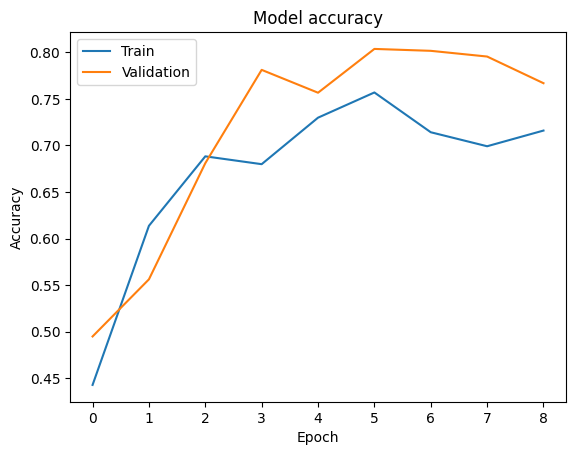

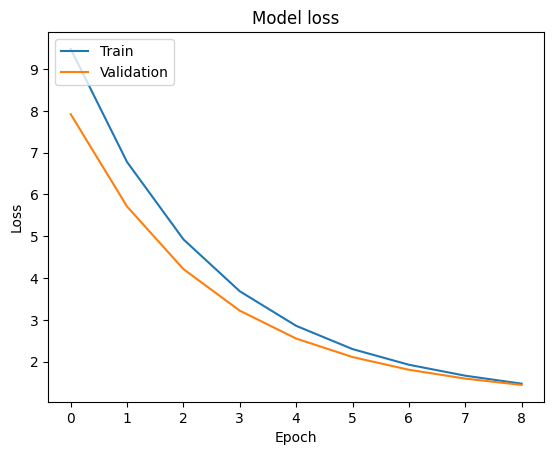

In [ ]:
#Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
#Menampilkan ringkasan model
from tensorflow.keras.models import load_model
model = load_model('GRU.keras')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100, 16)             │           7,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,941,995 (7.41 MB)

 Trainable params: 647,331 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,294,664 (4.94 MB)

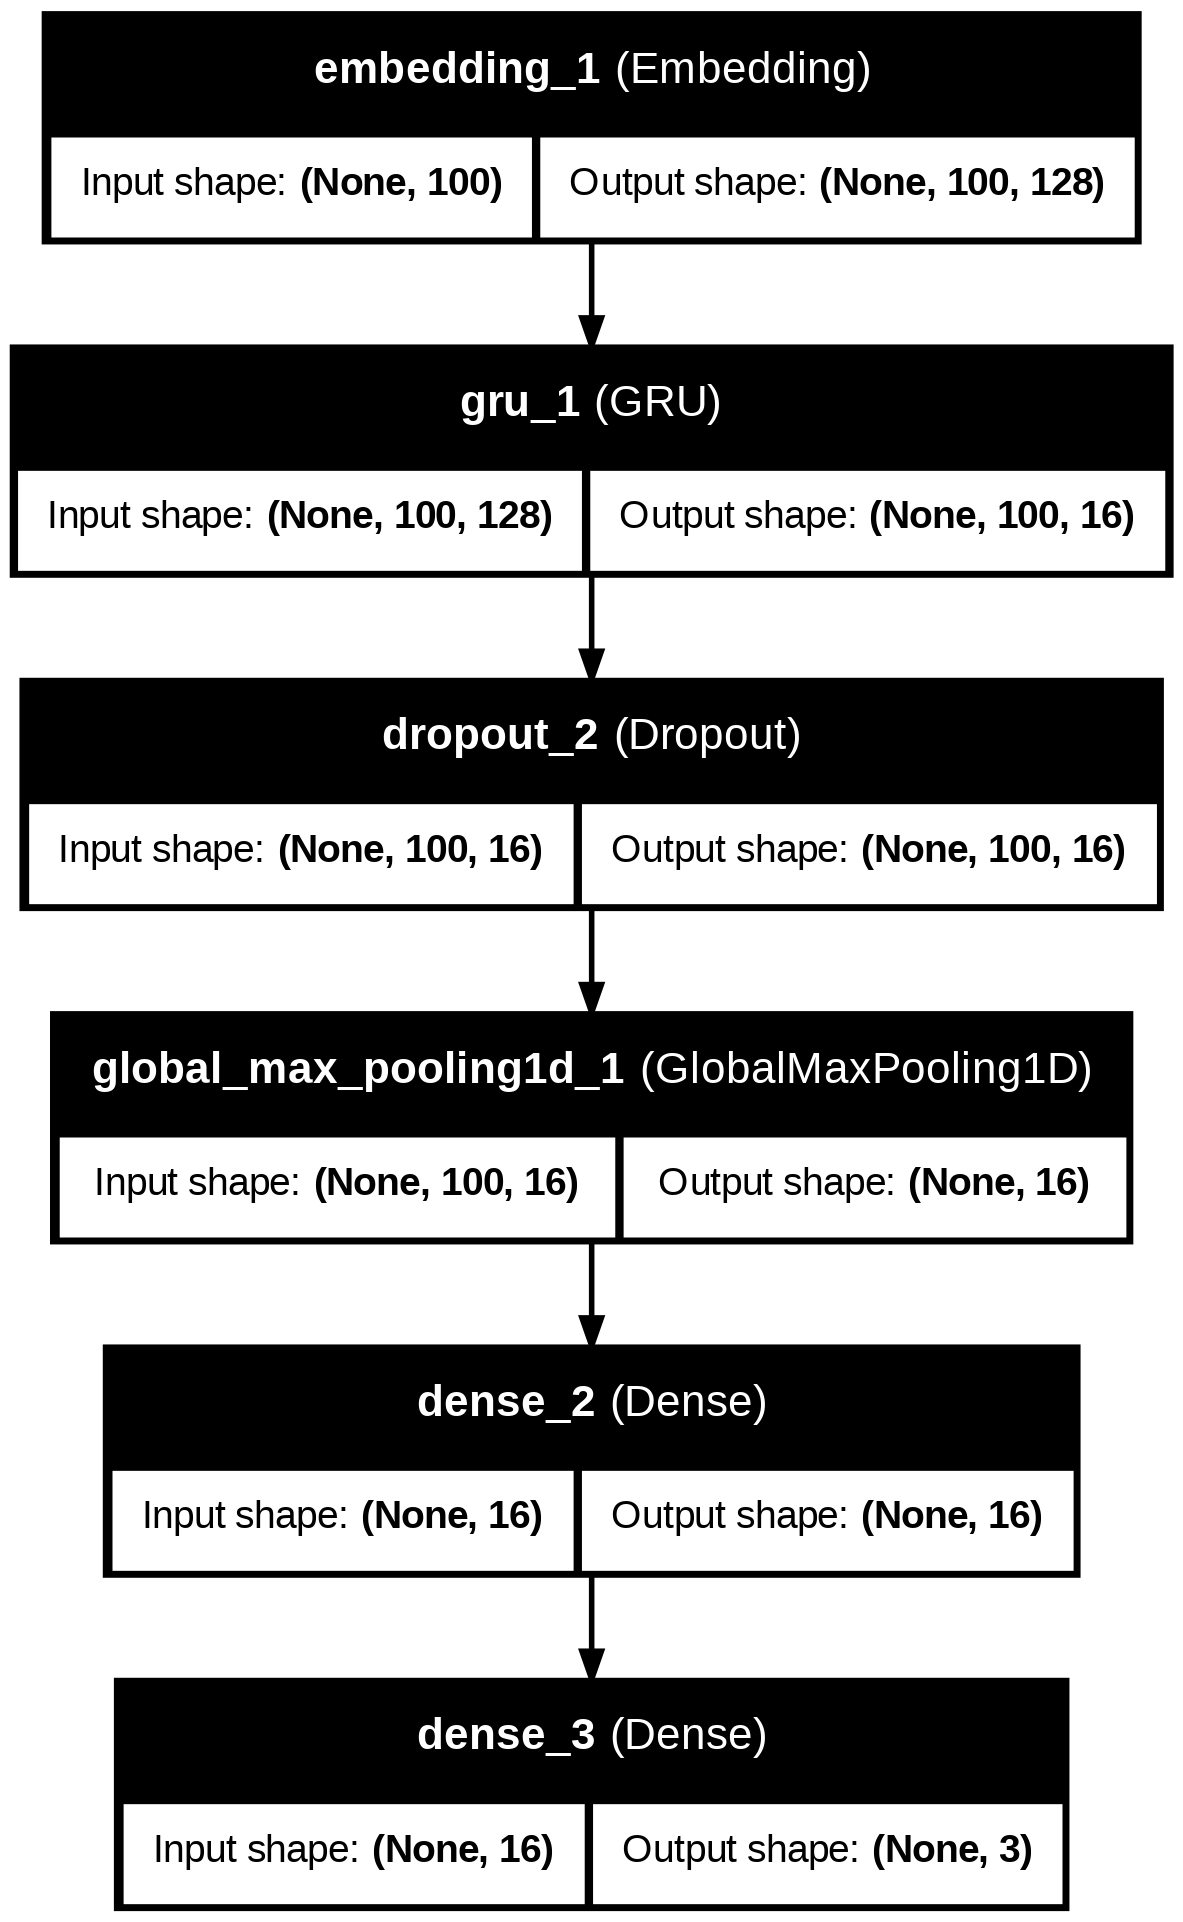

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
#Penebakan data baru

model = load_model('GRU.keras')

#Fungsi untuk preprocessing teks
def preprocess_text(text):
    #Ubah ke huruf kecil
    text = text.lower()
    #Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #Hapus mention (@) dan hashtag (#)
    text = re.sub(r'@\w+|#\w+', '', text)
    #Hapus retweet (RT)
    text = re.sub(r'\brt\b', '', text)
    #Hapus angka dan simbol lainnya
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    #Menghapus stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

def predict_sentiment_bulk(file_path):
    new_data = pd.read_csv(file_path)

    #Memastikan kolom text ada
    if 'text' not in new_data.columns:
        raise ValueError("Kolom 'text' tidak ditemukan dalam file CSV.")

    #Preprocessing setiap teks dalam kolom text
    new_data['text'] = new_data['text'].apply(preprocess_text)

    #Tokenisasi dan padding untuk setiap tweet dalam file baru
    sequences = tokenizer.texts_to_sequences(new_data['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    #Prediksi sentimen
    predictions = model.predict(padded)

    #Mengambil kelas sentimen dari prediksi
    sentiments = np.argmax(predictions, axis=1)

    #Konversi kembali ke label asli (-1, 0, 1)
    sentiment_labels = label_encoder.inverse_transform(sentiments)

    #Menambahkan kolom sentimen ke data asli
    new_data['Sentiment'] = sentiment_labels

    #Memisahkan data berdasarkan sentimen (-1, 0, 1)
    df_negative = new_data[new_data['Sentiment'] == -1]
    df_neutral = new_data[new_data['Sentiment'] == 0]
    df_positive = new_data[new_data['Sentiment'] == 1]

    return df_negative, df_neutral, df_positive

df_neg, df_neu, df_pos = predict_sentiment_bulk('/content/appleReviewcsv.csv')

#Menampilkan ringkasan
print("Jumlah Tweet Negatif:", len(df_neg))
print("Jumlah Tweet Netral:", len(df_neu))
print("Jumlah Tweet Positif:", len(df_pos))

outputneg = 'defneg.csv'
outputneu = 'defneu.csv'
outputpos = 'defpos.csv'

df_neg.to_csv(outputneg, index=False)
df_neu.to_csv(outputneu, index=False)
df_pos.to_csv(outputpos, index=False)

files.download(outputneg)
files.download(outputneu)
files.download(outputpos)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Jumlah Tweet Negatif: 51
Jumlah Tweet Netral: 25
Jumlah Tweet Positif: 24


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Jumlah Tweet Negatif: 51
Jumlah Tweet Netral: 25
Jumlah Tweet Positif: 24


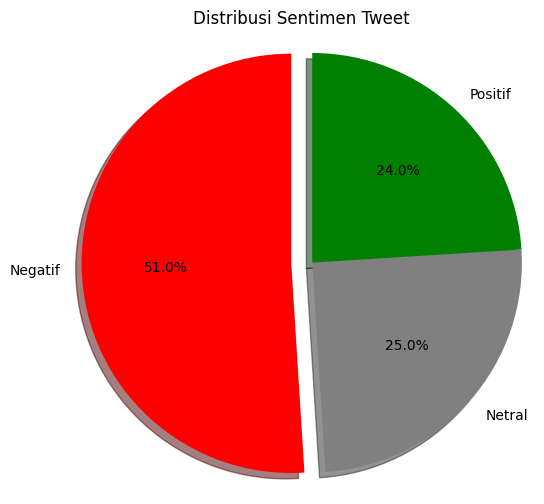

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

negdata = pd.read_csv('/content/defneg (1).csv')
neudata = pd.read_csv('/content/defneu (1).csv')
posdata = pd.read_csv('/content/defpos (1).csv')

jmlhneg = len(negdata)
jmlhneu = len(neudata)
jmlhpos = len(posdata)

print("Jumlah Tweet Negatif:", jmlhneg)
print("Jumlah Tweet Netral:", jmlhneu)
print("Jumlah Tweet Positif:", jmlhpos)

#pie chart
labels = ['Negatif', 'Netral', 'Positif']
sizes = [jmlhneg, jmlhneu, jmlhpos]
colors = ['red', 'gray', 'green']
explode = (0.1, 0, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Distribusi Sentimen Tweet')
plt.axis('equal')

plt.show()


In [ ]:
#Mencari kata atau topic yang berpengaruh

#Load spaCy model
nlp = spacy.load('en_core_web_sm')

#Membaca file CSV
df = pd.read_csv('/content/appleReviewcsv.csv')

# Pastikan kolom yang benar (ganti 'text' jika kolom berbeda)
print(df.head())  # Tampilkan beberapa baris pertama untuk memastikan

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)#Hapus URL
    text = re.sub(r'@\w+|#\w+', '', text)#Hapus mention dan hashtag
    text = re.sub(r'\brt\b', '', text)#Hapus RT (retweet)
    text = re.sub(r'\d+', '', text)#Hapus angka
    text = re.sub(r'[^\w\s]', '', text)#Hapus simbol
    return text

# Preprocessing teks
df['processed_text'] = df['text'].apply(preprocess_text)

# Menentukan kata yang ingin dihapus
words_to_remove = ['review', 'apple','iphone','life','time','airpods']  # Ganti dengan kata-kata yang ingin dihapus

# Mengambil kata benda dan kata "product"
nouns = []
for doc in nlp.pipe(df['processed_text'], disable=["tokenizer", "parser", "ner"]):
    for token in doc:
        #Hanya simpan kata benda atau kata "product" yang bukan stop words dan tidak ada dalam words_to_remove
        if (token.pos_ == "NOUN" or token.text.lower() == "product") and not token.is_stop and token.text.lower() not in words_to_remove:
            nouns.append(token.text.lower())

#Menghitung frekuensi kata
nouns_counts = pd.Series(nouns).value_counts()

#Menampilkan 10 kata paling atas
print(nouns_counts.head(10))

                                                text
0  Received a response from Amanda on the review ...
1  When your @Apple product has been with you hal...
2  Yesterday's apple wasn't crunchy enough, and d...
3  A short correspondence with #AppleReview this ...
4  I love the Apple Watch Sport loop, but there a...
phone        56
battery      38
case         20
camera       18
screen       17
condition    15
quality      13
apples        9
product       8
scratches     8
Name: count, dtype: int64


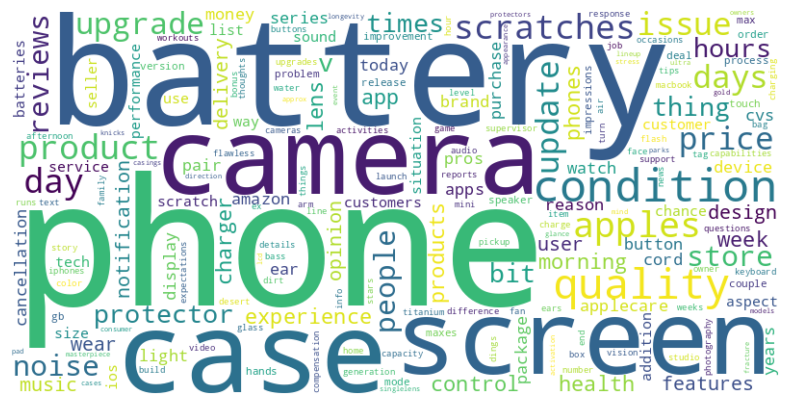

In [ ]:
from wordcloud import WordCloud

#Membuat word cloud

#Menghitung frekuensi kata dari nouns_counts (hasil yang sudah difilter)
word_frequencies = nouns_counts.to_dict()#Mengonversi Series menjadi dictionary untuk WordCloud

#Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')#Menghilangkan sumbu
plt.show()

In [ ]:
#Mengambil top 10 kata benda yang memiliki value_counts lebih dari 25
top_nouns = nouns_counts[nouns_counts > 10].head(10).index.tolist()

#Menampilkan array dari 10 kata benda teratas
print(top_nouns)


['phone', 'battery', 'case', 'camera', 'screen', 'condition', 'quality']


In [ ]:
#Melakukan penghitungan kesamaan pada nouns atau topic yang terpilih

#Unduh model GloVe
fasttext_model = api.load('glove-wiki-gigaword-50')

#Inisialisasi stopwords
stop_words = set(stopwords.words('english'))

#Fungsi untuk membersihkan dan mempreprocessing teks
def preprocess_text(text):
    #Ubah ke huruf kecil
    text = text.lower()
    #Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #Hapus mention (@) dan hashtag (#)
    text = re.sub(r'@\w+|#\w+', '', text)
    #Hapus retweet (RT)
    text = re.sub(r'\brt\b', '', text)
    #Hapus angka dan simbol lainnya
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    #Menghapus stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

#Fungsi untuk menghitung kesamaan teks dengan top nouns menggunakan FastText
def analisa(df, top_nouns):
    similarity_results = []

    #Pra-pemrosesan teks di DataFrame
    df['processed_text'] = df['text'].apply(preprocess_text)

    # Iterasi setiap teks dalam DataFrame yang sudah diproses
    for text in df['processed_text']:
        #Ambil kata-kata dalam teks yang sudah diproses
        words = text.split()

        #Buat dictionary untuk menyimpan skor similarity untuk setiap noun
        similarity_dict = {noun: 0 for noun in top_nouns}

        #Untuk setiap kata dalam teks, hitung kesamaan terhadap setiap noun
        for word in words:
            if word in fasttext_model.key_to_index:#Hanya jika kata ada di model FastText
                for noun in top_nouns:
                    if noun in fasttext_model.key_to_index:#Pastikan noun juga ada
                        similarity_score = fasttext_model.similarity(word, noun)
                        similarity_dict[noun] += similarity_score  #Tambahkan skor similarity untuk kata ini

        #Rata-rata skor similarity per noun
        for noun in similarity_dict:
            similarity_dict[noun] /= len(words) if words else 1#Rata-rata similarity untuk semua kata dalam teks

        similarity_results.append({'text': text, **similarity_dict})

    #Simpan hasil dalam DataFrame
    similarity_df = pd.DataFrame(similarity_results)

    #Simpan hasil ke file CSV
    output_file = '/content/fasttext_similarity_results.csv'
    similarity_df.to_csv(output_file, index=False)

    print(f"Similarity results saved to {output_file}")
    display(similarity_df)


csv_file_path = '/content/apple-twitter-sentiment-texts.csv'
df = pd.read_csv(csv_file_path)

analisa(df, top_nouns)


Similarity results saved to /content/fasttext_similarity_results.csv


,text,phone,battery,case,camera,screen,condition,quality
0,wow yall needa step music snapchat damn time t...,0.220059,0.052977,0.141816,0.197315,0.246272,0.135343,0.244104
1,happened apple inc,0.435214,0.234501,0.357369,0.270624,0.277967,0.215772,0.300334
2,thank u compile pics communicate one place,0.378710,0.184790,0.280332,0.309060,0.354404,0.259090,0.368437
3,oddly uplifting story apple cofounder sold sta...,0.299317,0.142887,0.227769,0.252239,0.289088,0.144654,0.258312
4,exchange iphone different color lmao changed mind,0.402834,0.245838,0.393387,0.391929,0.444881,0.337844,0.466201
...,...,...,...,...,...,...,...,...
1625,pick slack fuck boys,0.227884,0.166282,0.211106,0.256050,0.342970,0.170517,0.351498
1626,finally got iphone mail comes box busted scree...,0.526593,0.301403,0.429208,0.476845,0.541183,0.297183,0.438925
1627,ended getting new computer anyhow work compute...,0.398863,0.203097,0.282062,0.326171,0.346792,0.239316,0.358113
1628,yearold turned nabbed backing star,0.290613,0.155969,0.315816,0.287683,0.305383,0.189488,0.235045


In [ ]:
#Pembetulan format untuk data training
similarity_df = pd.read_csv('/content/fasttext_similarity_results.csv')

#Ubah nilai kolom nouns menjadi 0 atau 1
for noun in top_nouns:
    similarity_df[noun] = np.where(similarity_df[noun] > 0.39, 1, 0)

#Simpan hasil ke file CSV yang baru
output_file_final = '/content/fasttext_similarity_results_final.csv'
similarity_df.to_csv(output_file_final, index=False)

print(f"Final similarity results saved to {output_file_final}")

# Unduh file baru yang sudah diubah
# files.download(output_file_final)

Final similarity results saved to /content/fasttext_similarity_results_final.csv


Untuk 'phone':
phone
0    930
1    700
Name: count, dtype: int64

Untuk 'battery':
battery
0    1618
1      12
Name: count, dtype: int64

Untuk 'case':
case
0    1107
1     523
Name: count, dtype: int64

Untuk 'camera':
camera
0    1457
1     173
Name: count, dtype: int64

Untuk 'screen':
screen
0    1177
1     453
Name: count, dtype: int64

Untuk 'condition':
condition
0    1377
1     253
Name: count, dtype: int64

Untuk 'quality':
quality
0    980
1    650
Name: count, dtype: int64

Distribusi label sebelum SMOTE: Counter({0: 737, 1: 560})
Distribusi label setelah SMOTE: Counter({1: 737, 0: 737})
Classification report for phone:
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       185
           1       0.74      0.14      0.24       140

    accuracy                           0.61       325
   macro avg       0.67      0.55      0.49       325
weighted avg       0.66      0.61      0.52       325



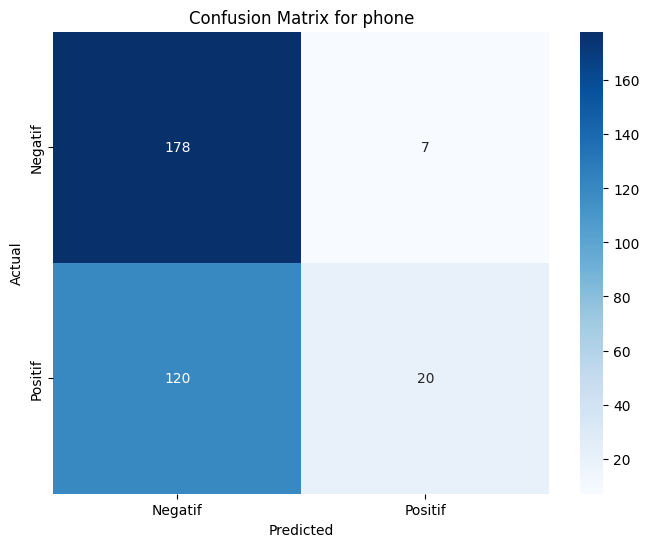

Distribusi label sebelum SMOTE: Counter({0: 1287, 1: 10})
Distribusi label setelah SMOTE: Counter({0: 1287, 1: 1287})
Classification report for battery:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       323
           1       0.00      0.00      0.00         2

    accuracy                           0.98       325
   macro avg       0.50      0.49      0.49       325
weighted avg       0.99      0.98      0.98       325



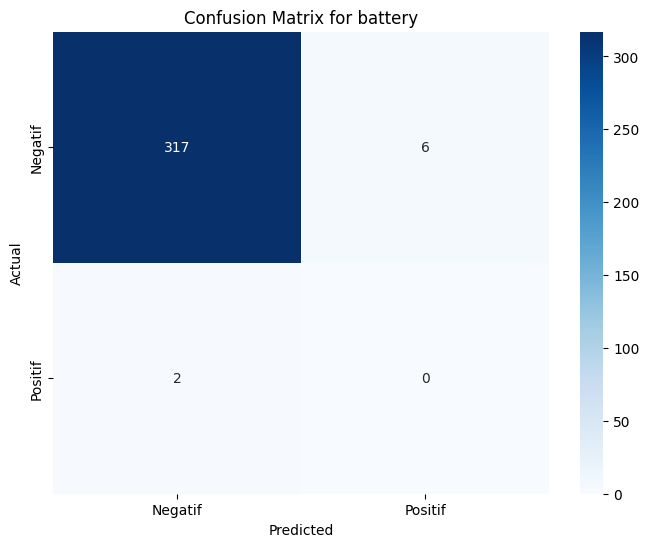

Distribusi label sebelum SMOTE: Counter({0: 879, 1: 418})
Distribusi label setelah SMOTE: Counter({1: 879, 0: 879})
Classification report for case:
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       220
           1       0.58      0.07      0.12       105

    accuracy                           0.68       325
   macro avg       0.64      0.52      0.46       325
weighted avg       0.65      0.68      0.58       325



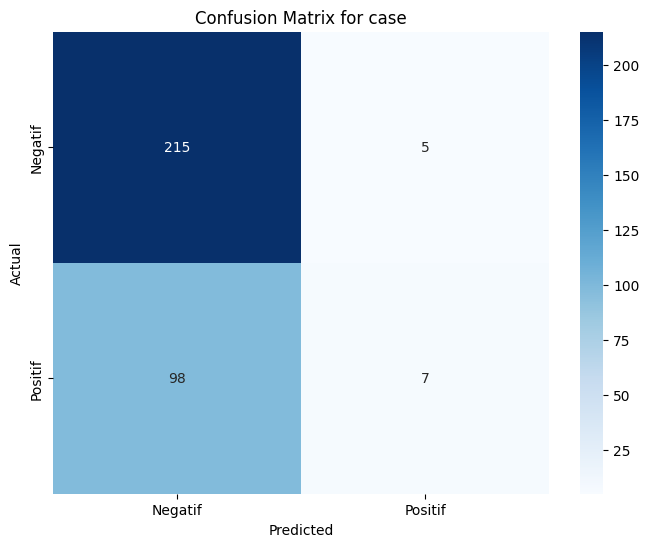

Distribusi label sebelum SMOTE: Counter({0: 1159, 1: 138})
Distribusi label setelah SMOTE: Counter({0: 1159, 1: 1159})
Classification report for camera:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       290
           1       0.11      0.09      0.10        35

    accuracy                           0.82       325
   macro avg       0.50      0.50      0.50       325
weighted avg       0.81      0.82      0.82       325



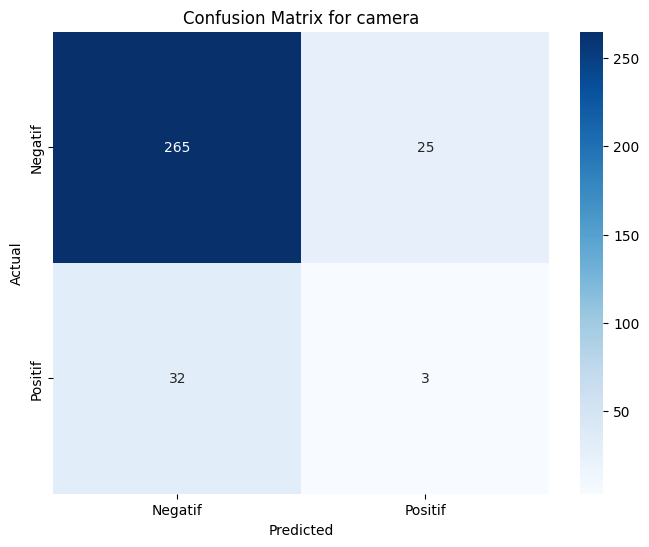

Distribusi label sebelum SMOTE: Counter({0: 935, 1: 362})
Distribusi label setelah SMOTE: Counter({0: 935, 1: 935})
Classification report for screen:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       234
           1       0.39      0.16      0.23        91

    accuracy                           0.70       325
   macro avg       0.56      0.53      0.52       325
weighted avg       0.64      0.70      0.65       325



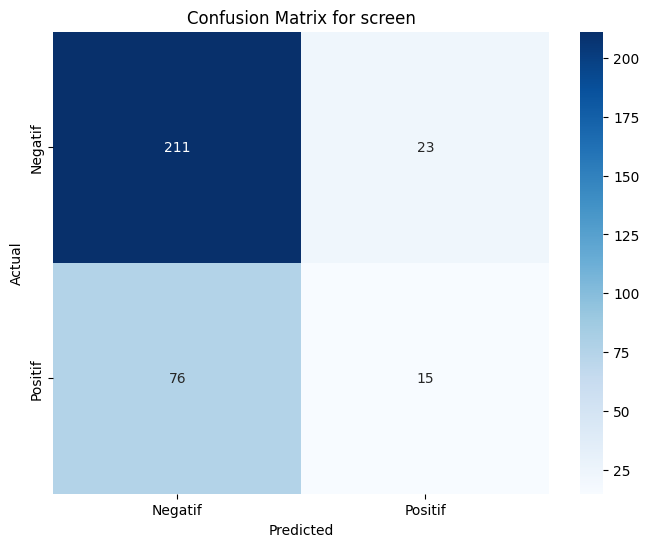

Distribusi label sebelum SMOTE: Counter({0: 1095, 1: 202})
Distribusi label setelah SMOTE: Counter({0: 1095, 1: 1095})
Classification report for condition:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       274
           1       0.22      0.10      0.14        51

    accuracy                           0.80       325
   macro avg       0.53      0.52      0.51       325
weighted avg       0.75      0.80      0.77       325



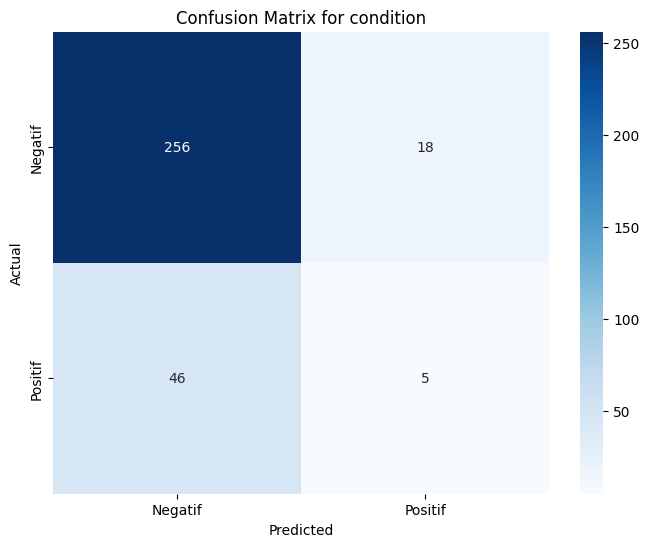

Distribusi label sebelum SMOTE: Counter({0: 777, 1: 520})
Distribusi label setelah SMOTE: Counter({0: 777, 1: 777})
Classification report for quality:
              precision    recall  f1-score   support

           0       0.50      0.07      0.13       195
           1       0.39      0.89      0.54       130

    accuracy                           0.40       325
   macro avg       0.45      0.48      0.33       325
weighted avg       0.46      0.40      0.29       325



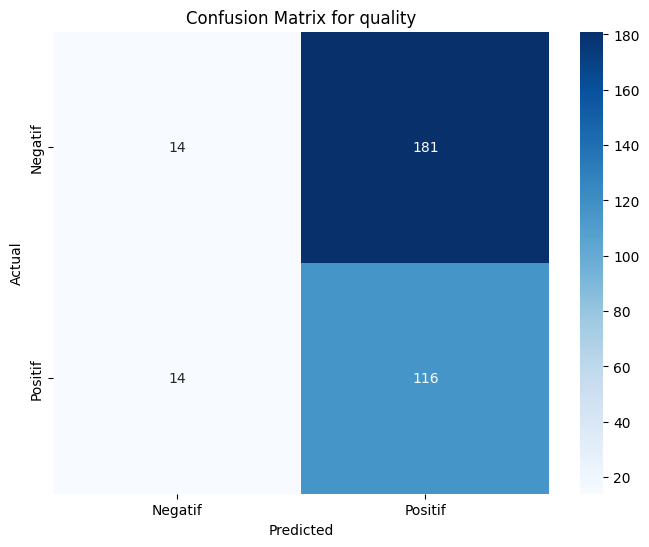

In [ ]:
#Pembuatan model randomForest untuk tiap topic/noun
nouns = top_nouns

for noun in nouns:
    counts = similarity_df[noun].value_counts()
    print(f"Untuk '{noun}':")
    print(counts)
    print()

similarity_df = pd.read_csv('/content/fasttext_similarity_results_final.csv')


vectorizer = TfidfVectorizer(vocabulary=top_nouns, ngram_range=(1, 2))
#Membuat model untuk setiap noun
models = {}
#Menghapus baris yang memiliki NaN di kolom 'text'
similarity_df = similarity_df.dropna(subset=['text'])
text_features = vectorizer.fit_transform(similarity_df['text']).toarray()


for noun in nouns:

    #Tambahkan fitur teks ke dataframe sebagai fitur X
    X2 = text_features

    #Target adalah kolom noun yang dipilih
    y2 = similarity_df[noun]

    #Membagi data menjadi train dan test
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

    smote = SMOTE(random_state=42)
    X_train_resampled2, y_train_resampled2 = smote.fit_resample(X_train2, y_train2)
    print(f'Distribusi label sebelum SMOTE: {Counter(y_train2)}')
    print(f'Distribusi label setelah SMOTE: {Counter(y_train_resampled2)}')
    #model Random Forest
    model = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42)
    model.fit(X_train_resampled2, y_train_resampled2)

    #Simpan model ke dictionary
    models[noun] = model

    #Evaluasi model
    y_pred2 = model.predict(X_test2)
    print(f"Classification report for {noun}:")
    print(classification_report(y_test2, y_pred2))
    cm = confusion_matrix(y_test2, y_pred2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {noun}')
    plt.show()

In [ ]:
#Melakukan penebakan untuk tiap text baru apakah berhubungan dengan topic, dengan model yang sudah di trai

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

#Membuat CountVectorizer global untuk digunakan pada pelatihan
vectorizer = CountVectorizer(vocabulary=top_nouns)

#Fungsi untuk mempersiapkan DataFrame untuk prediksi
def prepare_data_for_prediction(df):
    #Menggunakan CountVectorizer untuk mengubah teks menjadi fitur
    features = vectorizer.transform(df['text']).toarray()#Menggunakan transform untuk data baru
    return features

#Daftar hasil prediksi
predictions = {noun: {'neg': [], 'neu': [], 'pos': []} for noun in top_nouns}

#Melakukan prediksi untuk setiap noun
for noun in top_nouns:
    # Siapkan data untuk prediksi
    features_neg = prepare_data_for_prediction(df_neg)
    features_neu = prepare_data_for_prediction(df_neu)
    features_pos = prepare_data_for_prediction(df_pos)

    # Melakukan prediksi dan menyimpan hasilnya
    predictions[noun]['neg'] = models[noun].predict(features_neg)
    predictions[noun]['neu'] = models[noun].predict(features_neu)
    predictions[noun]['pos'] = models[noun].predict(features_pos)

#Membuat DataFrame untuk menyimpan hasil prediksi untuk setiap sentiment
predicted_df_neg = pd.DataFrame()
predicted_df_neu = pd.DataFrame()
predicted_df_pos = pd.DataFrame()

#Mengumpulkan hasil prediksi untuk DataFrame masing-masing
for noun in top_nouns:
    #Menyimpan hasil prediksi untuk neg
    temp_df_neg = pd.DataFrame(predictions[noun]['neg'], columns=[noun])
    predicted_df_neg = pd.concat([predicted_df_neg, temp_df_neg], axis=1)

    #Menyimpan hasil prediksi untuk neu
    temp_df_neu = pd.DataFrame(predictions[noun]['neu'], columns=[noun])
    predicted_df_neu = pd.concat([predicted_df_neu, temp_df_neu], axis=1)

    #Menyimpan hasil prediksi untuk pos
    temp_df_pos = pd.DataFrame(predictions[noun]['pos'], columns=[noun])
    predicted_df_pos = pd.concat([predicted_df_pos, temp_df_pos], axis=1)

#Menambahkan kolom teks ke DataFrame
predicted_df_neg['text'] = df_neg['text'].values
predicted_df_neu['text'] = df_neu['text'].values
predicted_df_pos['text'] = df_pos['text'].values

#Menyimpan hasil prediksi ke file CSV
predicted_df_neg.to_csv('/content/predictions_df_neg.csv', index=False)
predicted_df_neu.to_csv('/content/predictions_df_neu.csv', index=False)
predicted_df_pos.to_csv('/content/predictions_df_pos.csv', index=False)
files.download('/content/predictions_df_neg.csv')
files.download('/content/predictions_df_neu.csv')
files.download('/content/predictions_df_pos.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Menghitung jumlah 1/berpengaruh untuk setiap noun dalam df_neg, df_neu, dan df_pos
counts = {}

counts['Neg'] = {noun: sum(predictions[noun]['neg']) for noun in top_nouns}

counts['Neu'] = {noun: sum(predictions[noun]['neu']) for noun in top_nouns}

counts['Pos'] = {noun: sum(predictions[noun]['pos']) for noun in top_nouns}

#Menampilkan hasil
for sentiment, count in counts.items():
    print(f"Jumlah 1 untuk setiap noun di {sentiment}:")
    for noun, count_1 in count.items():
        print(f"{noun}: {count_1}")
    print()


Jumlah 1 untuk setiap noun di Neg:
phone: 30
battery: 9
case: 21
camera: 26
screen: 31
condition: 7
quality: 32

Jumlah 1 untuk setiap noun di Neu:
phone: 4
battery: 0
case: 4
camera: 4
screen: 0
condition: 0
quality: 25

Jumlah 1 untuk setiap noun di Pos:
phone: 6
battery: 2
case: 6
camera: 4
screen: 1
condition: 0
quality: 23



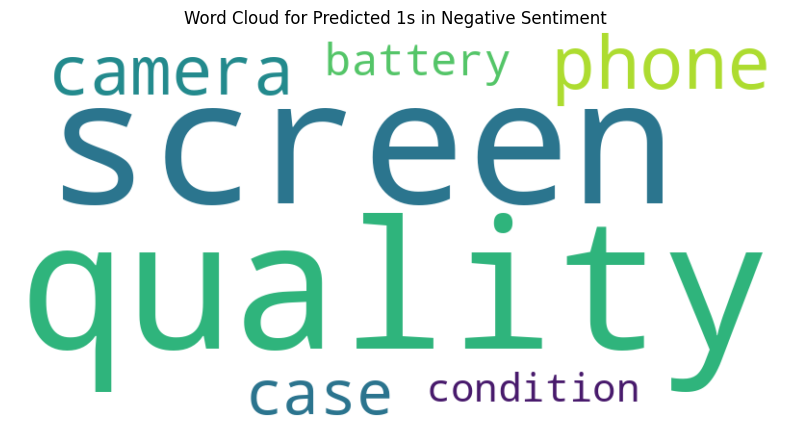

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud(counts['Neg'], 'Word Cloud for Predicted 1s in Negative Sentiment')



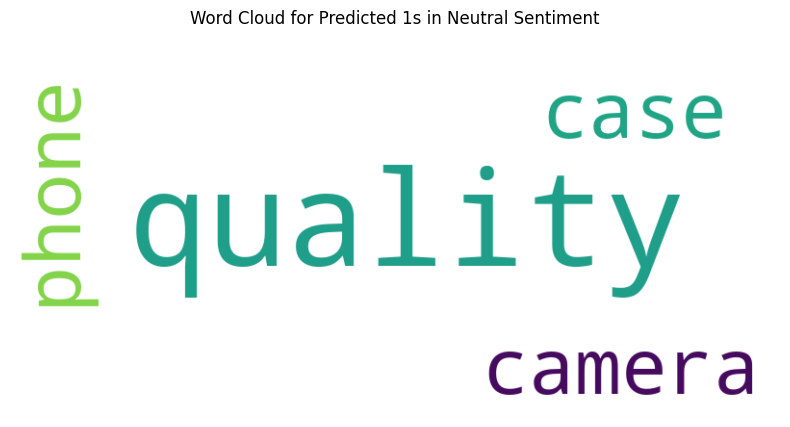

In [ ]:
create_wordcloud(counts['Neu'], 'Word Cloud for Predicted 1s in Neutral Sentiment')

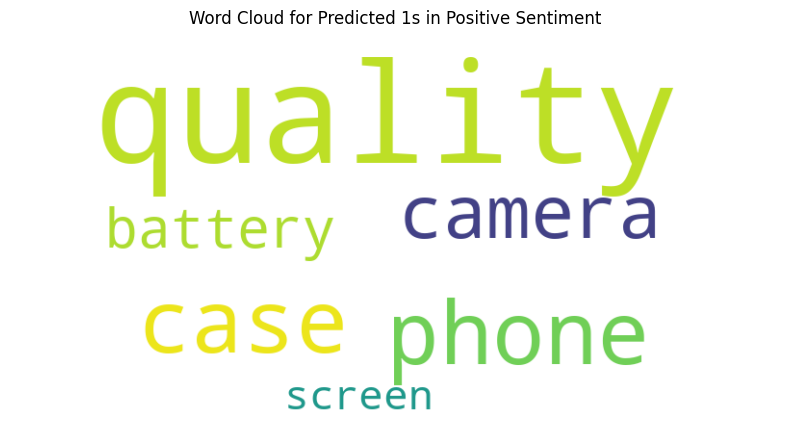

In [ ]:
create_wordcloud(counts['Pos'], 'Word Cloud for Predicted 1s in Positive Sentiment')

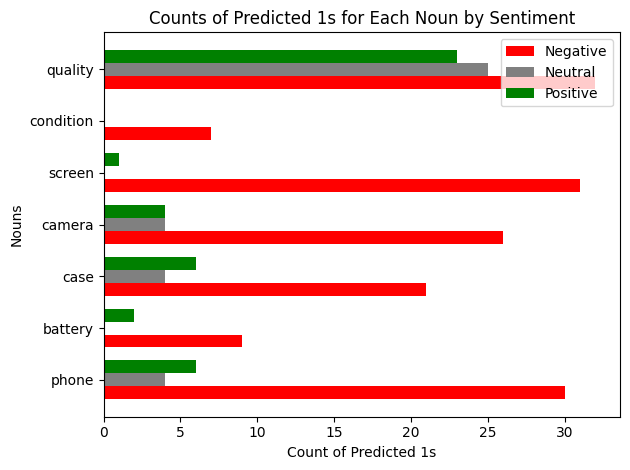

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

nouns = top_nouns
neg_counts = [counts['Neg'][noun] for noun in nouns]
neu_counts = [counts['Neu'][noun] for noun in nouns]
pos_counts = [counts['Pos'][noun] for noun in nouns]

bar_width = 0.25
y = np.arange(len(nouns))

#horizontal bar charts
plt.barh(y, neg_counts, height=bar_width, label='Negative', color='red')
plt.barh(y + bar_width, neu_counts, height=bar_width, label='Neutral', color='gray')
plt.barh(y + 2 * bar_width, pos_counts, height=bar_width, label='Positive', color='green')

plt.ylabel('Nouns')
plt.xlabel('Count of Predicted 1s')
plt.title('Counts of Predicted 1s for Each Noun by Sentiment')
plt.yticks(y + bar_width, nouns)
plt.legend()
plt.tight_layout()
plt.show()
